# **Cluster Image Colors**
The following code inputs an image, which is then clustered into a specified number of clusters using mini batch *k*-means. The picture is then recompiled using it's colors found during clustering, thus condensing the size of the image by a factor of around 1 million!

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import io
from PIL import Image
from google.colab import files
from pdb import set_trace as bp
def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  file_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return file_path

img_path = upload()

Upload Content Image


Saving ProfilePicture.jpeg to ProfilePicture.jpeg


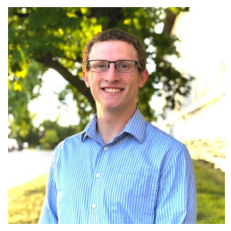

In [27]:
from skimage import data, io, filters
from PIL import Image 
### Load Data
image = np.asarray(Image.open(img_path, mode='r'))
### Plot picture data
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(image)

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [28]:
image.shape

(400, 400, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [29]:
data = image / 255.0 # use 0...1 scale
data = data.reshape(data.shape[0] * data.shape[1], 3)
data.shape

(160000, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [30]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

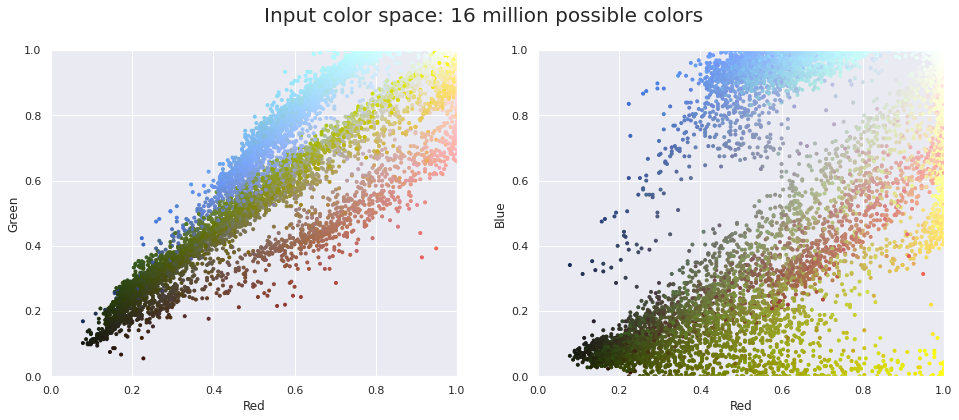

In [31]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

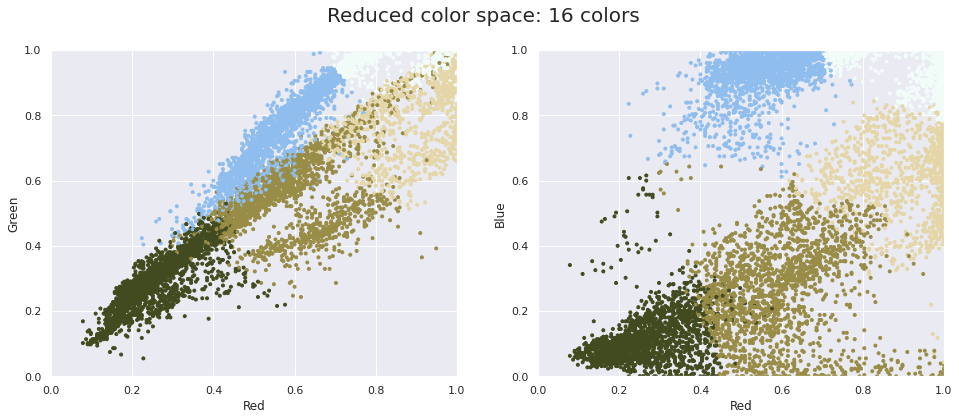

In [39]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(5)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

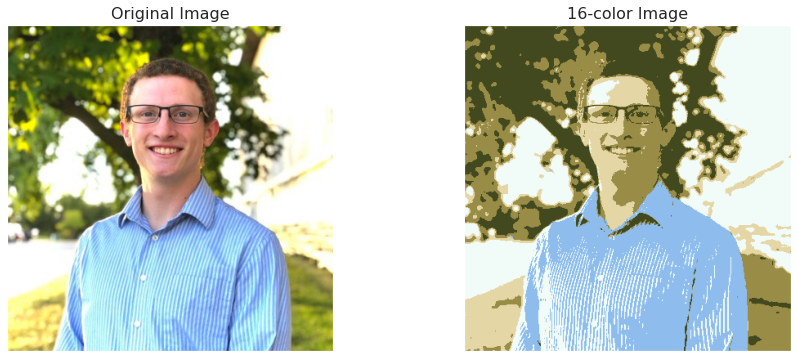

In [40]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.